# Whole-body ODE Models with Python

[Download this notebook](https://github.com/8BM050/{{< var repo >}}/blob/main/8bm050/notebooks/02-whole-body-models.ipynb){.btn .btn-success .mr-4 }

This notebook accompanies chapter 6 of the lecture notes. In this notebook, we will take a look at:

1. Model extensions
2. Modeling delays
3. Combining simulations for subsequent perturbations

## Packages
Below the packages we will use in this notebook are imported.

In [24]:
# | code-fold: true

import matplotlib.pyplot as plt
from math import exp
from scipy.integrate import odeint
import numpy as np

## Model Extension
A simple kinetic model for a whole-body system is given by the following set of ODEs:

\begin{align}
\frac{\mathrm{d}C_1}{\mathrm{d}t} &= -(k_1 + k_0) C_1 + k_2 C_2 \\
\frac{\mathrm{d}C_2}{\mathrm{d}t} &= k_1 C_1 - k_2 C_2
\end{align}

where $C_1$ and $C_2$ are the concentrations in compartment 1 and compartment 2, and $k_0$, $k_1$, and $k_2$ are rate constants. This model can be implemented in Python as follows:

In [25]:
def compartment_model(c, t, k0, k1, k2):

    dC1 = -(k1 + k0) * c[0] + k2 * c[1]
    dC2 = k1*c[0] - k2 * c[1]

    return [dC1, dC2]


We may want to extend this model, for example, a first-order appearance term of $C_1$ from a new compartment $C_0$. The model then becomes:

\begin{align}
\frac{\mathrm{d}C_0}{\mathrm{d}t} &= -k_3 C_0 \\
\frac{\mathrm{d}C_1}{\mathrm{d}t} &= -k_0 C_1 - k_1 C_1 + k_2 C_2 + k_3 C_0 \\
\frac{\mathrm{d}C_2}{\mathrm{d}t} &= k_1 C_1 - k_2 C_2
\end{align}

A way to extend the current model in Python, is to build a new function of the extended model, that calls the original model function. This is shown in the code below.

In [ ]:
def extended_compartment_model(c, t, k0, k1, k2, k3):
    dC0 = -k3*c[0]
    dC1, dC2 = compartment_model(c[1:3], t, k0, k1, k2)

    dC1 += k3*c[0]

    return [dC0, dC1, dC2]

We can then use the `odeint` function from the `scipy.integrate` module to solve the ODEs, which is similar to the previous notebook.

### Exercise 1)
Simulate the compartment model and the extended compartment model for the following parameters:
- $k_0 = 0.1$
- $k_1 = 0.15$
- $k_2 = 0.32$
- $k_3 = 0.2$

Use the initial conditions $C_0(0) = 1$, $C_1(0) = 1$, and $C_2(0) = 0$. Plot the concentrations as a function of time.

In [27]:
# Your code here!

## Modeling Delays
In the lecture notes and in the lectures, delay compartments were introduced. Delay compartments are implemented in the same way as a normal equation. Consider the model:

$$
\begin{align}
\frac{\mathrm{d}C_0}{\mathrm{d}t} &= -k_0 C_0 \\
\frac{\mathrm{d}C_{\text{end}}}{\mathrm{d}t} &= k_0 C_0 - k_{\text{end}} C_1 
\end{align}
$$

where $C_0$ is the input compartment, and $C_{\text{end}}$ is the output compartment. We can add a delay compartment $C_1$, which is a first-order compartment with a rate constant $k_1$. The model then becomes:

$$
\begin{align}
\frac{\mathrm{d}C_0}{\mathrm{d}t} &= -k_0 C_0 \\
\frac{\mathrm{d}C_1}{\mathrm{d}t} &= k_0 C_0 - k_1 C_1 \\
\frac{\mathrm{d}C_{\text{end}}}{\mathrm{d}t} &= k_1 C_1 - k_{\text{end}} C_{\text{end}}
\end{align}
$$

We can implement this model in Python in the same way as the previous models. The code below shows how to implement this model.

In [28]:
def zero_delay(c, t, k0, kend):

    dc0 = -k0*c[0]
    dcend = k0*c[0] - kend*c[-1]

    return [dc0, dcend]


def one_delay(c, t, k0, k1, kend):
    dc0 = -k0*c[0]
    dc1 = k0*c[0] - k1*c[1]
    dcend = k1*c[1] - kend*c[-1]

    return [dc0, dc1, dcend]

### Exercise 2)
Simulate the delay compartment model for the following parameters:
- $k_0 = 0.1$
- $k_1 = 0.15$

Use the initial conditions $C_0(0) = 1$, $C_1(0) = 0$, and $C_{\text{end}}(0) = 0$. Plot the concentrations of $C_{\text{end}}$ as a function of time. Compare the results with the model without the delay compartment.

In [29]:
# Your code here!


### Exercise 3)
Create a model with two, three and four delay compartments. Each delay compartment has the same rate constant $k_1$. Simulate the model for the parameters given in exercise 2. Plot the concentrations of $C_{\text{end}}$ as a function of time for each model in one plot. Explain the effect of the number of delay compartments on the output.

In [30]:
# Your code here!

## Combining Simulations for Subsequent Perturbations
For example, when modeling multiple subsequent bolus injections at different times, we need to combine different simulations into one. This can be done by running the simulation for the first perturbation, and then using the final concentrations as initial conditions for the next simulation. The code below shows how to do this.


An example the following simple system can be:

$$\frac{\mathrm{d}x}{\mathrm{d}t} = -kx $$

Where we have an initial value of $x = 2.0$ at $t = 0$, and add another dose of $2.0$ at $t = 4$.

We can first implement the model:

In [31]:
def simple_model(x, t, k):
    return -k*x

k = 0.5
x0 = 2.0

We can then do the first simulation, up to $t=4.0$

In [32]:
simulation_1 = odeint(simple_model, x0, np.linspace(0,4,100), args=(k,))

We can then do the second simulation, taking the final timepoint of the first as initial condition and adding the second dose.

In [33]:
# the new initial condition is the end of simulation 1 plus the dose
x0_2 = simulation_1[-1] + 2.0

# simulate with the new initial condition, starting where the previous simulation ended
simulation_2 = odeint(simple_model, x0_2, np.linspace(4,10,100), args=(k,))

We can then combine both simulations and visualize the result.

In [34]:
# combine the timepoints
timepoints = np.concatenate([np.linspace(0,4,100), np.linspace(4,10,100)])
simulation = np.concatenate([simulation_1, simulation_2])

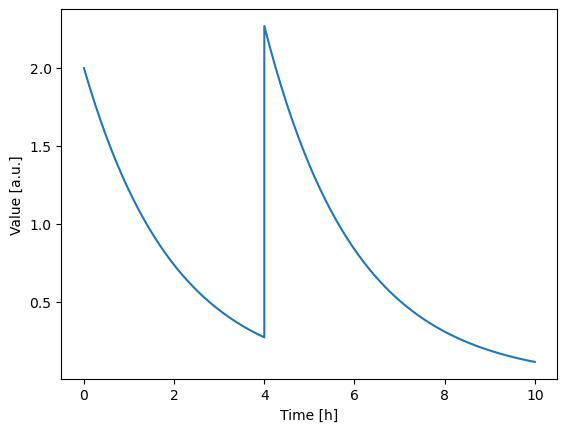

In [35]:
# | fig-cap: Two sequential perturbations of the simulated ODE system.
# | code-fold: true 
# | lightbox: true 

# visualize
plt.plot(timepoints, simulation)
plt.xlabel("Time [h]")
plt.ylabel("Value [a.u.]")
plt.show()

### Exercise 4)
Combine three simulations of the previous model with the following perturbations:
- $x = 2.0$ at $t = 0$
- $x = x + 2.0$ at $t = 4$
- $x = x + 2.0$ at $t = 8$